# Traffic signs detection project #
Section 2: extracting features and using them on 3 models.

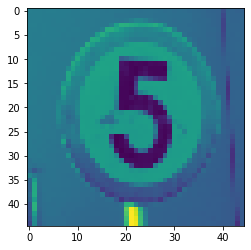

In [125]:
# Load the saved pictures:
import numpy as np
import matplotlib.pyplot as plt
import os

saved = np.load(os.path.join("Features",'featuresTrain.npy'))
plt.imshow(saved[0])

In [126]:
# Change array of pictures of size 45x45 to array of pictures 45*45=2025:
x = saved
x = x.astype("float32") / 255
rows, cols = (4170, 2025)
newX = np.array([[0]*cols]*rows)
newX = newX.astype("float32")
jump = 0
for i in range(0,rows):
    for j in range(0, 45):
        for k in range(0, 45):
            newX[i][jump] = x[i][j][k]
            jump = jump + 1
    jump = 0

In [127]:
# Load the classification vector (classes):
f = open("tsrd-train-y.txt", "r")
str = f.read()

lines = str.split("\n")
arr = []
for line in lines:
    arr.append(int(line.split(";")[7]))

classes = []
for i in range(58):
    classes.append(arr.count(i))

classes = []
for i in range(58):
    for k in range(arr.count(i)):
        classes.append(i)

1994
(1994, 2025)


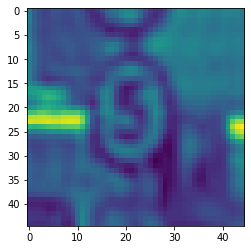

In [128]:
# Same proccessing for the test set:
saved_test = np.load(os.path.join("Features",'featuresTest.npy'))
plt.imshow(saved_test[0])
# Change array of pictures (45x45) to array of pictures 45x45=2025:
x = saved_test
x = x.astype("float32") / 255
rows, cols = (1994, 2025)
newX_test = np.array([[0]*cols]*rows)
newX_test = newX_test.astype("float32")
jump = 0
for i in range(0,rows):
    for j in range(0, 45):
        for k in range(0, 45):
            newX_test[i][jump] = x[i][j][k]
            jump = jump + 1
    jump = 0
# Load the classification vector:
f = open("TSRD-TEST-y.txt", "r")
str = f.read()

lines = str.split("\n")
arr = []
for line in lines:
    arr.append(int(line.split(";")[7]))

classes_test = []
for i in range(58):
    classes_test.append(arr.count(i))

classes_test = []
for i in range(58):
    for k in range(arr.count(i)):
        classes_test.append(i)
print(len(classes_test))
print(newX_test.shape)

In [129]:
# Use PCA and LDA:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pca = PCA(n_components=10)
x_pca = pca.fit(newX).transform(newX)
x_pca_test = pca.fit(newX_test).transform(newX_test)
#print(pca.explained_variance_ratio_)
#print(x_pca[0])
lda = LinearDiscriminantAnalysis(n_components=10)
x_lda = lda.fit(newX, classes).transform(newX)
x_lda_test = lda.fit(newX_test, classes_test).transform(newX_test)
#print(lda.explained_variance_ratio_)
#print(x_lda[0])

[ 4 16  5 ... 17 11 17]
0.058174523570712136
[ 7 14 14 ... 29 29 29]
0.028084252758274825


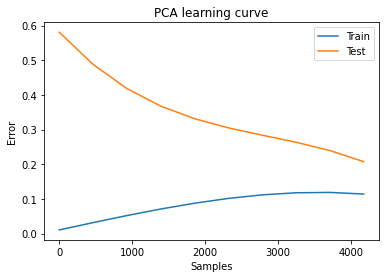

Pretty good.


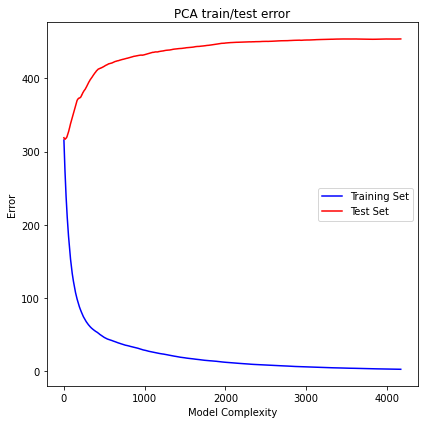

Not good on the test.


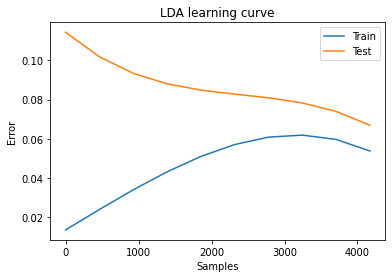

Too much samples - got to an overfitting state.


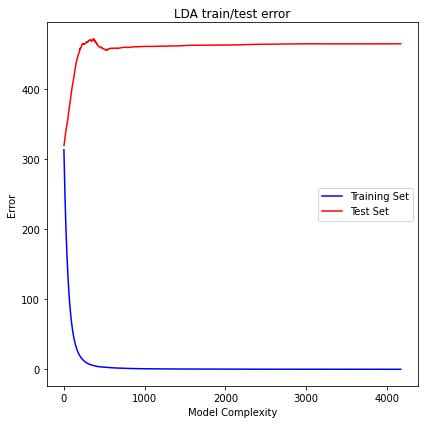

Not good on the test.


In [130]:
# Use RF model:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import ensemble
from sklearn.metrics import mean_squared_error

clf1 = RandomForestClassifier(max_depth=10, random_state=0)
clf2 = RandomForestClassifier(max_depth=10, random_state=0)
clf1.fit(x_pca, classes)
clf2.fit(x_lda, classes)

print(clf1.predict(x_pca_test))
print(clf1.score(x_pca_test, classes_test))
print(clf2.predict(x_lda_test))
print(clf2.score(x_lda_test, classes_test))

#  Print it's learning curves (PCA):
curveSize = 10 # Decide the length of the curves.
testErr = []
trainErr = []

for i in range(1, curveSize+1):
    X_train, X_test, y_train, y_test = ( 
    train_test_split(np.append(x_pca, x_pca_test, axis=0), np.append(classes, classes_test, axis=0), train_size=(i/(curveSize+1))) 
    # Append more samples until we get all of them. train_size devides the samples according to the loop variable (curveSize+1).
    )
    clf1.fit(X_train, y_train)
    y_predict = clf1.predict(X_train)
    trainErr.append(1-accuracy_score(y_train, y_predict))
    y_predict = clf1.predict(X_test)
    testErr.append(1-accuracy_score(y_test, y_predict))


plt.xlabel("Samples")
plt.ylabel("Error")
x = np.linspace(0, 4170, curveSize) 
y1 = np.polyfit(x, trainErr, 3)
p1 = np.poly1d(y1)
y2 = np.polyfit(x, testErr, 3)
p2 = np.poly1d(y2)

plt.plot(x, p1(x), label="Train")
plt.plot(x, p2(x), label="Test")
plt.title("PCA learning curve")
plt.legend(loc="best") 
plt.show()
print("Pretty good.")


params = {
    "n_estimators": 4170, 
    "max_depth": 5,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(x_pca, classes)
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(x_pca_test)):
    test_score[i] = reg.loss_(classes_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set"
)
plt.xlabel("Model Complexity")
plt.ylabel("Error")
plt.title("PCA train/test error")
fig.tight_layout()
plt.legend(loc="best")
plt.show()
print("Not good on the test.")


#  Print it's learning curves (LDA):
testErr = []
trainErr = []

for i in range(1, curveSize+1):
    X_train, X_test, y_train, y_test = ( 
    train_test_split(np.append(x_lda, x_lda_test, axis=0), np.append(classes, classes_test, axis=0), train_size=(i/(curveSize+1))) 
    )
    clf2.fit(X_train, y_train)
    y_predict = clf2.predict(X_train)
    trainErr.append(1-accuracy_score(y_train, y_predict))
    y_predict = clf2.predict(X_test)
    testErr.append(1-accuracy_score(y_test, y_predict))


plt.xlabel("Samples")
plt.ylabel("Error")
x = np.linspace(0, 4170, curveSize) 
y1 = np.polyfit(x, trainErr, 3) 
p1 = np.poly1d(y1)
y2 = np.polyfit(x, testErr, 3)
p2 = np.poly1d(y2)

plt.plot(x, p1(x), label="Train")
plt.plot(x, p2(x), label="Test")
plt.title("LDA learning curve")
plt.legend(loc="best") 
plt.show()
print("Too much samples - got to an overfitting state.")

params = {
    "n_estimators": 4170, 
    "max_depth": 5,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(x_lda, classes)
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(x_lda_test)):
    test_score[i] = reg.loss_(classes_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set"
)
plt.xlabel("Model Complexity")
plt.ylabel("Error")
plt.title("LDA train/test error")
fig.tight_layout()
plt.legend(loc="best")
plt.show()
print("Not good on the test.")

[ 4 17 17 ... 57 16 57]
0.058174523570712136
[14 14 14 ... 45 45 45]
0.05917753259779338


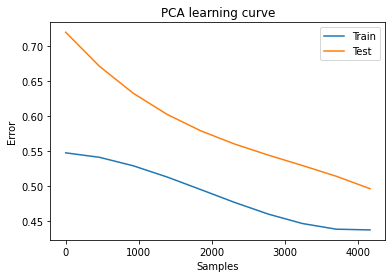

Pretty good.


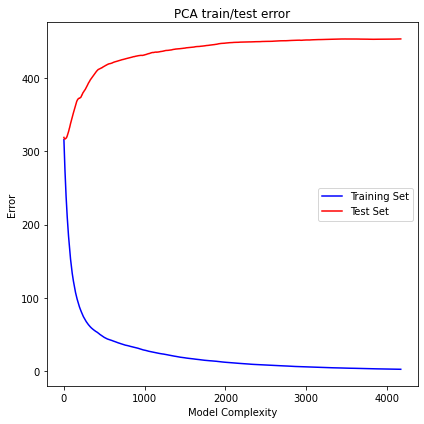

Not good on the test.


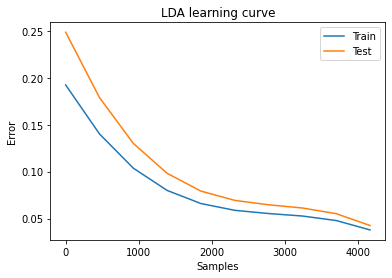

Pretty good.


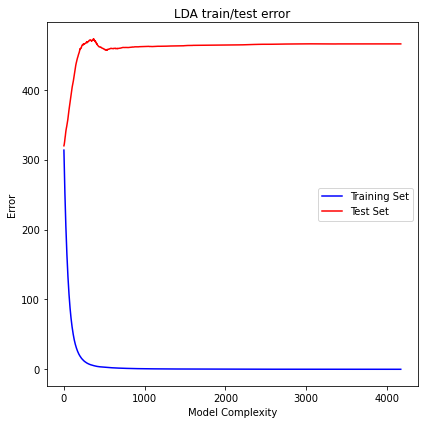

Not good on the test.


In [131]:
# Use SVM model:
from sklearn import svm

svc1 = svm.SVC(kernel='rbf')
svc2 = svm.SVC(kernel='rbf')
svc1.fit(x_pca, classes)
svc2.fit(x_lda, classes)
print(svc1.predict(x_pca_test))
print(svc1.score(x_pca_test, classes_test))
print(svc2.predict(x_lda_test))
print(svc2.score(x_lda_test, classes_test))

#  Print it's learning curves (PCA):
curveSize = 10 # Decide the length of the curves.
testErr = []
trainErr = []

for i in range(1, curveSize+1):
    X_train, X_test, y_train, y_test = ( 
    train_test_split(np.append(x_pca, x_pca_test, axis=0), np.append(classes, classes_test, axis=0), train_size=(i/(curveSize+1))) 
    # Append more samples until we get all of them. train_size devides the samples according to the loop variable (curveSize+1).
    )
    svc1.fit(X_train, y_train)
    y_predict = svc1.predict(X_train)
    trainErr.append(1-accuracy_score(y_train, y_predict))
    y_predict = svc1.predict(X_test)
    testErr.append(1-accuracy_score(y_test, y_predict))


plt.xlabel("Samples")
plt.ylabel("Error")
x = np.linspace(0, 4170, curveSize) 
y1 = np.polyfit(x, trainErr, 3) 
p1 = np.poly1d(y1)
y2 = np.polyfit(x, testErr, 3)
p2 = np.poly1d(y2)

plt.plot(x, p1(x), label="Train")
plt.plot(x, p2(x), label="Test")
plt.title("PCA learning curve")
plt.legend(loc="best") 
plt.show()
print("Pretty good.")


params = {
    "n_estimators": 4170, 
    "max_depth": 5,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(x_pca, classes)
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(x_pca_test)):
    test_score[i] = reg.loss_(classes_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set"
)
plt.xlabel("Model Complexity")
plt.ylabel("Error")
plt.title("PCA train/test error")
fig.tight_layout()
plt.legend(loc="best")
plt.show()
print("Not good on the test.")


#  Print it's learning curves (LDA):
testErr = []
trainErr = []

for i in range(1, curveSize+1):
    X_train, X_test, y_train, y_test = ( 
    train_test_split(np.append(x_lda, x_lda_test, axis=0), np.append(classes, classes_test, axis=0), train_size=(i/(curveSize+1))) 
    )
    svc2.fit(X_train, y_train)
    y_predict = svc2.predict(X_train)
    trainErr.append(1-accuracy_score(y_train, y_predict))
    y_predict = svc2.predict(X_test)
    testErr.append(1-accuracy_score(y_test, y_predict))


plt.xlabel("Samples")
plt.ylabel("Error")
x = np.linspace(0, 4170, curveSize) 
y1 = np.polyfit(x, trainErr, 3) 
p1 = np.poly1d(y1)
y2 = np.polyfit(x, testErr, 3)
p2 = np.poly1d(y2)

plt.plot(x, p1(x), label="Train")
plt.plot(x, p2(x), label="Test")
plt.title("LDA learning curve")
plt.legend(loc="best") 
plt.show()
print("Pretty good.")

params = {
    "n_estimators": 4170, 
    "max_depth": 5,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(x_lda, classes)
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(x_lda_test)):
    test_score[i] = reg.loss_(classes_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set"
)
plt.xlabel("Model Complexity")
plt.ylabel("Error")
plt.title("LDA train/test error")
fig.tight_layout()
plt.legend(loc="best")
plt.show()
print("Not good on the test.")

[ 4 16 54 ... 54 11 54]
0.044132397191574725
[14 14 14 ... 43 43 43]
0.058174523570712136


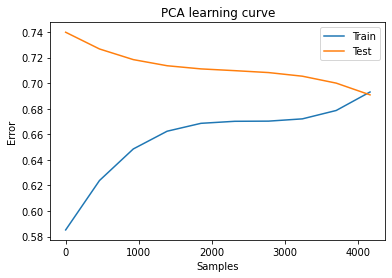

Pretty good.


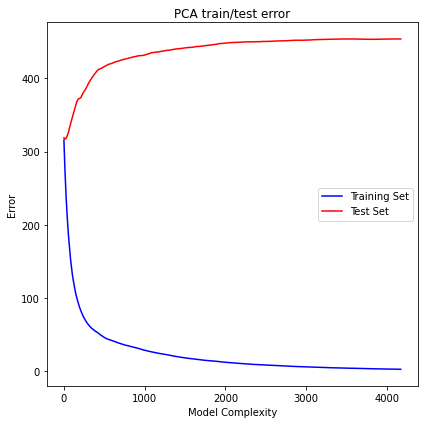

Not good on the test.


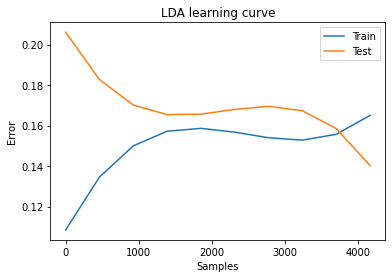

Too much samples - got to an overfitting state.


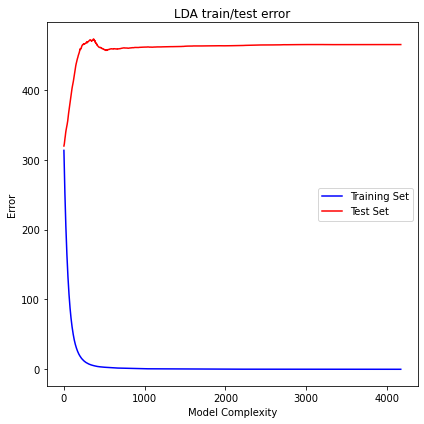

Not good on the test.


In [134]:
# Use NB model:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import GaussianNB

gnb1 = GaussianNB()
gnb2 = GaussianNB()
gnb1.fit(x_pca, classes)
gnb2.fit(x_lda, classes)

print(gnb1.predict(x_pca_test))
print(gnb1.score(x_pca_test, classes_test))
print(gnb2.predict(x_lda_test))
print(gnb2.score(x_lda_test, classes_test))

#  Print it's learning curves (PCA):
testErr = []
trainErr = []

for i in range(1, curveSize+1):
    X_train, X_test, y_train, y_test = ( 
    train_test_split(np.append(x_pca, x_pca_test, axis=0), np.append(classes, classes_test, axis=0), train_size=(i/(curveSize+1))) 
    # Append more samples until we get all of them. train_size devides the samples according to the loop variable (curveSize+1).
    )
    gnb1.fit(X_train, y_train)
    y_predict = gnb1.predict(X_train)
    trainErr.append(1-accuracy_score(y_train, y_predict))
    y_predict = gnb1.predict(X_test)
    testErr.append(1-accuracy_score(y_test, y_predict))


plt.xlabel("Samples")
plt.ylabel("Error")
x = np.linspace(0, 4170, curveSize) 
y1 = np.polyfit(x, trainErr, 3)
p1 = np.poly1d(y1)
y2 = np.polyfit(x, testErr, 3)
p2 = np.poly1d(y2)

plt.plot(x, p1(x), label="Train")
plt.plot(x, p2(x), label="Test")
plt.title("PCA learning curve")
plt.legend(loc="best") 
plt.show()
print("Pretty good.")


params = {
    "n_estimators": 4170, 
    "max_depth": 5,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(x_pca, classes)
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(x_pca_test)):
    test_score[i] = reg.loss_(classes_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set"
)
plt.xlabel("Model Complexity")
plt.ylabel("Error")
plt.title("PCA train/test error")
fig.tight_layout()
plt.legend(loc="best")
plt.show()
print("Not good on the test.")


#  Print it's learning curves (LDA):
testErr = []
trainErr = []

for i in range(1, curveSize+1):
    X_train, X_test, y_train, y_test = ( 
    train_test_split(np.append(x_lda, x_lda_test, axis=0), np.append(classes, classes_test, axis=0), train_size=(i/(curveSize+1))) 
    )
    gnb2.fit(X_train, y_train)
    y_predict = gnb2.predict(X_train)
    trainErr.append(1-accuracy_score(y_train, y_predict))
    y_predict = gnb2.predict(X_test)
    testErr.append(1-accuracy_score(y_test, y_predict))


plt.xlabel("Samples")
plt.ylabel("Error")
x = np.linspace(0, 4170, curveSize) 
y1 = np.polyfit(x, trainErr, 3) 
p1 = np.poly1d(y1)
y2 = np.polyfit(x, testErr, 3)
p2 = np.poly1d(y2)

plt.plot(x, p1(x), label="Train")
plt.plot(x, p2(x), label="Test")
plt.title("LDA learning curve")
plt.legend(loc="best") 
plt.show()
print("Too much samples - got to an overfitting state.")

params = {
    "n_estimators": 4170, 
    "max_depth": 5,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(x_lda, classes)
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(x_lda_test)):
    test_score[i] = reg.loss_(classes_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set"
)
plt.xlabel("Model Complexity")
plt.ylabel("Error")
plt.title("LDA train/test error")
fig.tight_layout()
plt.legend(loc="best")
plt.show()
print("Not good on the test.")